In [ ]:
# Association Rule Mining Lab - Apriori vs FP-Growth

**Name:** Milan Bista 
**Course:** 2025 Summer - Advanced Big Data and Data Mining (MSCS-634-M40) - Full Term 
**Lab Assignment:** Lab 6: Association Rule Mining with Apriori and FP-Growth

## Lab Overview
This lab explores association rule mining using Apriori and FP-Growth algorithms to analyze transactional 
data and identify meaningful patterns in customer purchasing behavior.


In [23]:
import pandas as pd

# Load CSVs
orders = pd.read_csv('orders.csv')
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

# Merge order_products with orders and product names
order_prod = pd.concat([prior, train], ignore_index=True)
df = order_prod.merge(orders[['order_id', 'user_id']], on='order_id')
df = df.merge(products[['product_id', 'product_name']], on='product_id')

# Use only prior orders to keep dataset smaller
df = df[df['order_id'].isin(prior['order_id'])].copy()

# Create basket (order_id → items matrix)
basket = df.groupby(['order_id', 'product_name']).size().unstack(fill_value=0)
transactions = basket.applymap(lambda x: 1 if x >= 1 else 0)

print(transactions.shape)
transactions.head()


FileNotFoundError: [Errno 2] No such file or directory: 'orders.csv'

In [21]:

# Step 1: Data Preparation
# Install required packages (run once in your environment)
# pip install kagglehub mlxtend seaborn matplotlib pandas

## Download and Load Kaggle Groceries Dataset
print("Downloading Groceries Market Basket Dataset from Kaggle...")
print("Dataset: https://www.kaggle.com/datasets/irfanasrullah/groceries")

# Download dataset
path = dataset_download("irfanasrullah/groceries")
print("Dataset downloaded to:", path)
print("Files:", os.listdir(path))

# Load the CSV file
csv_file = os.path.join(path, "./groceries.csv")
df = pd.read_csv(csv_file)
print(df.head())

print("\nDataset loaded successfully!")
print("Dataset shape:", df.shape)
print("Dataset columns:", df.columns.tolist())
print("\nFirst 5 records:")
print(df.head())

# Process the data to create transaction lists
# Group by Member_number to create transaction lists
transactions = df.groupby('Member_number')['itemDescription'].apply(list).tolist()

print(f"\n=== DATASET PROCESSED ===")
print(f"Total transactions: {len(transactions)}")
print(f"Sample transactions:")
for i in range(3):
    print(f"Transaction {i+1}: {transactions[i][:5]}{'...' if len(transactions[i]) > 5 else ''}")


## Data Exploration

# Get all unique items and their frequencies
all_items = [item for transaction in transactions for item in transaction]
item_counts = Counter(all_items)
unique_items = len(item_counts)
total_items = len(all_items)

print(f"\nDataset Statistics:")
print(f"Unique items: {unique_items}")
print(f"Total item purchases: {total_items}")
print(f"Average items per transaction: {total_items/len(transactions):.2f}")

# Top items analysis
top_items = item_counts.most_common(15)
print(f"\nTop 15 most frequent items:")
for item, count in top_items[:10]:
    print(f"{item}: {count} ({count/len(transactions)*100:.1f}%)")

# Visualization 1: Most frequent items
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
items, counts = zip(*top_items)
sns.barplot(x=list(counts), y=list(items), palette='viridis')
plt.title('Top 15 Most Frequent Items')
plt.xlabel('Frequency')

# Visualization 2: Transaction lengths
transaction_lengths = [len(t) for t in transactions]
plt.subplot(2, 2, 2)
sns.histplot(transaction_lengths, bins=20, kde=True, color='skyblue')
plt.title('Transaction Length Distribution')
plt.xlabel('Items per Transaction')
plt.ylabel('Frequency')

# Visualization 3: Item frequency distribution
plt.subplot(2, 2, 3)
frequency_counts = list(item_counts.values())
sns.histplot(frequency_counts, bins=30, kde=True, color='coral')
plt.title('Item Frequency Distribution')
plt.xlabel('Item Frequency')
plt.ylabel('Number of Items')

# Visualization 4: Cumulative frequency
plt.subplot(2, 2, 4)
sorted_counts = sorted(frequency_counts, reverse=True)
cumulative_pct = np.cumsum(sorted_counts) / sum(sorted_counts) * 100
plt.plot(range(1, len(sorted_counts)+1), cumulative_pct, marker='o', markersize=2)
plt.title('Cumulative Item Frequency Distribution')
plt.xlabel('Item Rank')
plt.ylabel('Cumulative Percentage')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Co-occurrence analysis for top items
def create_cooccurrence_heatmap(transactions, top_n=12):
    """Create co-occurrence matrix for top items"""
    top_items_list = [item for item, _ in item_counts.most_common(top_n)]
    matrix = np.zeros((len(top_items_list), len(top_items_list)))
    
    for transaction in transactions:
        for i, item1 in enumerate(top_items_list):
            for j, item2 in enumerate(top_items_list):
                if item1 in transaction and item2 in transaction:
                    matrix[i][j] += 1
    
    return pd.DataFrame(matrix, index=top_items_list, columns=top_items_list)

cooc_matrix = create_cooccurrence_heatmap(transactions)
plt.figure(figsize=(10, 8))
sns.heatmap(cooc_matrix, annot=True, cmap='YlOrRd', fmt='.0f', cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Item Co-occurrence Matrix (Top 12 Items)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Dataset: https://www.kaggle.com/datasets/irfanasrullah/groceries
Dataset downloaded to: /Users/milanbista/.cache/kagglehub/datasets/irfanasrullah/groceries/versions/2
Files: ['groceries.csv', 'groceries - groceries.csv']


ParserError: Error tokenizing data. C error: Expected 4 fields in line 6, saw 5


Encoded dataset shape: (800, 15)

Applying Apriori (min_support=0.05)...
Execution time: 0.0107s
Frequent itemsets found: 152

Top 5 frequent itemsets:
   support   itemsets
9  0.53375     (Milk)
3  0.48875   (Butter)
2  0.48500    (Bread)
0  0.44125   (Apples)
1  0.43375  (Bananas)


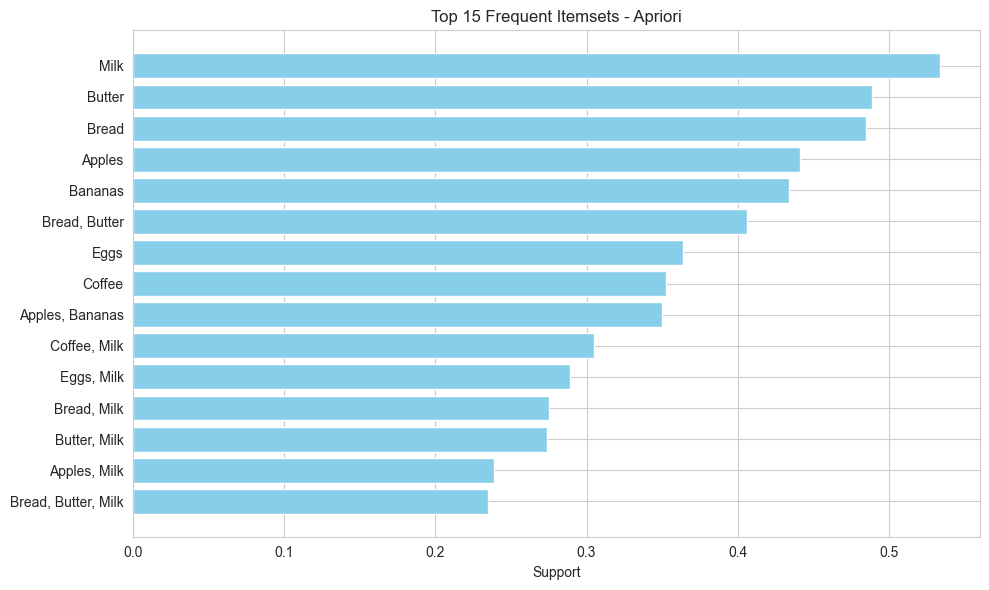

In [6]:
# Step 2: Apriori Algorithm

## Prepare Data for Mining
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_data, columns=te.columns_)
print(f"Encoded dataset shape: {df.shape}")

## Apply Apriori
min_support = 0.05
print(f"\nApplying Apriori (min_support={min_support})...")

start_time = time.time()
frequent_itemsets_apriori = apriori(df, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time

frequent_itemsets_apriori = frequent_itemsets_apriori.sort_values('support', ascending=False)
print(f"Execution time: {apriori_time:.4f}s")
print(f"Frequent itemsets found: {len(frequent_itemsets_apriori)}")
print("\nTop 5 frequent itemsets:")
print(frequent_itemsets_apriori.head())

## Visualize Apriori Results
plt.figure(figsize=(10, 6))
top_15 = frequent_itemsets_apriori.head(15)
labels = [', '.join(list(itemset)) for itemset in top_15['itemsets']]
plt.barh(range(len(top_15)), top_15['support'], color='skyblue')
plt.yticks(range(len(top_15)), labels)
plt.xlabel('Support')
plt.title('Top 15 Frequent Itemsets - Apriori')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Applying FP-Growth (min_support=0.05)...
Execution time: 0.1390s
Frequent itemsets found: 152

Top 5 frequent itemsets:
   support   itemsets
4  0.53375     (Milk)
0  0.48875   (Butter)
1  0.48500    (Bread)
8  0.44125   (Apples)
9  0.43375  (Bananas)


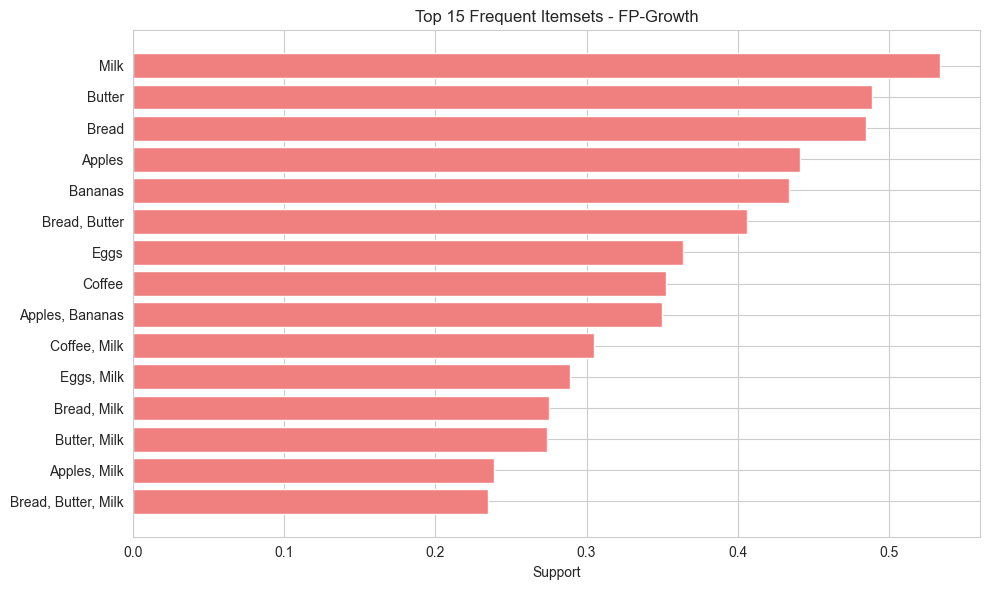

In [7]:
# Step 3: FP-Growth Algorithm

## Apply FP-Growth
print(f"Applying FP-Growth (min_support={min_support})...")

start_time = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

frequent_itemsets_fpgrowth = frequent_itemsets_fpgrowth.sort_values('support', ascending=False)
print(f"Execution time: {fpgrowth_time:.4f}s")
print(f"Frequent itemsets found: {len(frequent_itemsets_fpgrowth)}")
print("\nTop 5 frequent itemsets:")
print(frequent_itemsets_fpgrowth.head())

## Visualize FP-Growth Results
plt.figure(figsize=(10, 6))
top_15_fp = frequent_itemsets_fpgrowth.head(15)
labels_fp = [', '.join(list(itemset)) for itemset in top_15_fp['itemsets']]
plt.barh(range(len(top_15_fp)), top_15_fp['support'], color='lightcoral')
plt.yticks(range(len(top_15_fp)), labels_fp)
plt.xlabel('Support')
plt.title('Top 15 Frequent Itemsets - FP-Growth')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Generating association rules (min_confidence=0.3)...
Association rules generated: 681

Top 5 association rules:
Bread, Apples, Coffee → Butter, Bananas, Milk
  Support: 0.052, Confidence: 0.667, Lift: 5.735

Butter, Bananas, Milk → Bread, Apples, Coffee
  Support: 0.052, Confidence: 0.452, Lift: 5.735

Bread, Apples, Milk → Coffee, Butter, Bananas
  Support: 0.052, Confidence: 0.424, Lift: 5.474

Coffee, Butter, Bananas → Bread, Apples, Milk
  Support: 0.052, Confidence: 0.677, Lift: 5.474

Apples, Coffee, Butter → Bread, Bananas, Milk
  Support: 0.052, Confidence: 0.636, Lift: 5.474



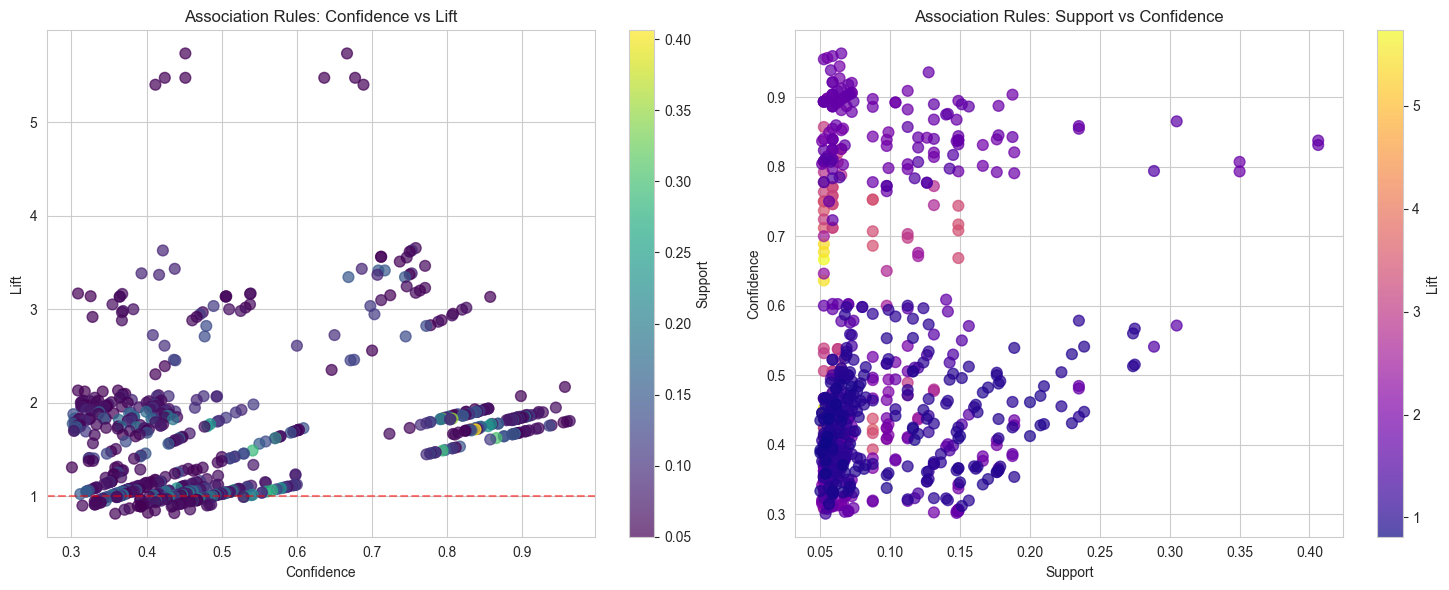

In [8]:
# Step 4: Association Rules Generation

## Generate Rules
min_confidence = 0.3
print(f"Generating association rules (min_confidence={min_confidence})...")

rules = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence)
rules = rules.sort_values('lift', ascending=False)

print(f"Association rules generated: {len(rules)}")
print("\nTop 5 association rules:")
for idx, rule in rules.head(5).iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))
    print(f"{antecedent} → {consequent}")
    print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}\n")

## Visualize Association Rules
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confidence vs Lift scatter plot
axes[0].scatter(rules['confidence'], rules['lift'], c=rules['support'], 
                cmap='viridis', alpha=0.7, s=60)
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Lift')
axes[0].set_title('Association Rules: Confidence vs Lift')
axes[0].axhline(y=1, color='red', linestyle='--', alpha=0.5)
plt.colorbar(axes[0].collections[0], ax=axes[0], label='Support')

# Support vs Confidence scatter plot
axes[1].scatter(rules['support'], rules['confidence'], c=rules['lift'], 
                cmap='plasma', alpha=0.7, s=60)
axes[1].set_xlabel('Support')
axes[1].set_ylabel('Confidence')
axes[1].set_title('Association Rules: Support vs Confidence')
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Lift')

plt.tight_layout()
plt.show()

=== COMPARATIVE ANALYSIS ===

Performance Comparison:
Apriori execution time: 0.0107s
FP-Growth execution time: 0.1390s
Speed improvement: 0.08x faster with FP-Growth

Results Comparison:
Frequent itemsets - Apriori: 152
Frequent itemsets - FP-Growth: 152
Results identical: True


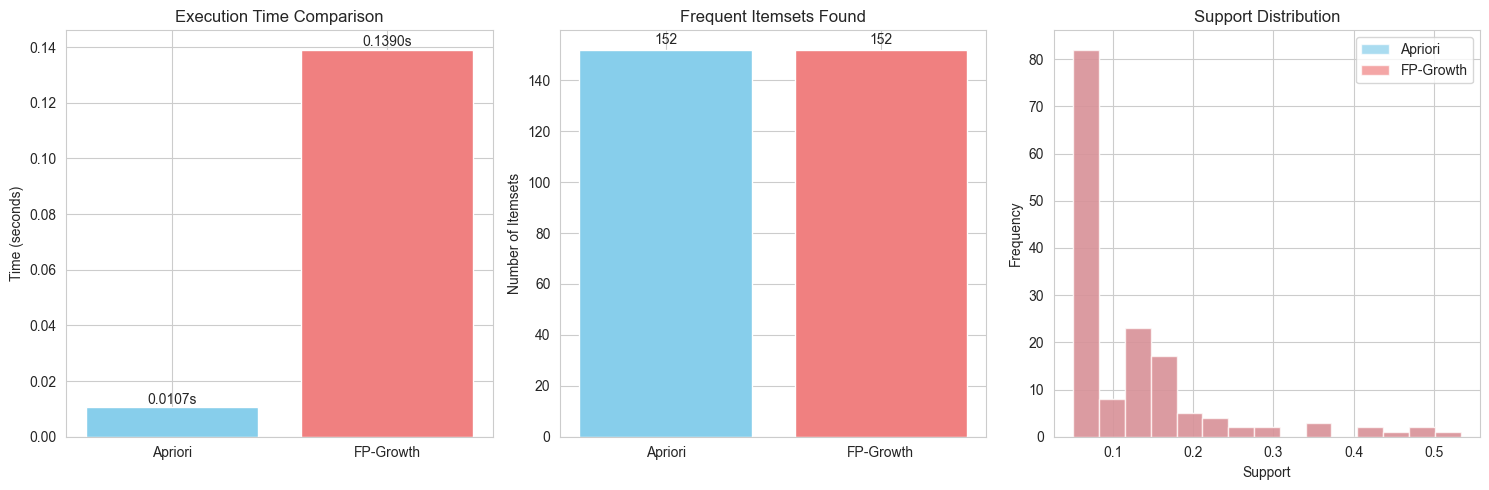


=== KEY INSIGHTS ===
Dataset: 800 transactions, 15 unique items
Most frequent item: Milk (427 occurrences)
Average transaction length: 4.1 items

Strong associations found:
• Bread, Apples, Coffee → Butter, Bananas, Milk (Conf: 0.667, Lift: 5.735)
• Coffee, Butter, Bananas → Bread, Apples, Milk (Conf: 0.677, Lift: 5.474)
• Apples, Coffee, Butter → Bread, Bananas, Milk (Conf: 0.636, Lift: 5.474)

Algorithm recommendation: FP-Growth for better performance
Both algorithms produce identical results, confirming correctness

=== LAB COMPLETED ===


In [9]:
# Step 5: Comparative Analysis

## Performance Comparison
print("=== COMPARATIVE ANALYSIS ===")
print(f"\nPerformance Comparison:")
print(f"Apriori execution time: {apriori_time:.4f}s")
print(f"FP-Growth execution time: {fpgrowth_time:.4f}s")
print(f"Speed improvement: {apriori_time/fpgrowth_time:.2f}x faster with FP-Growth")

print(f"\nResults Comparison:")
print(f"Frequent itemsets - Apriori: {len(frequent_itemsets_apriori)}")
print(f"Frequent itemsets - FP-Growth: {len(frequent_itemsets_fpgrowth)}")
print(f"Results identical: {len(frequent_itemsets_apriori) == len(frequent_itemsets_fpgrowth)}")

## Summary Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Execution time comparison
algorithms = ['Apriori', 'FP-Growth']
times = [apriori_time, fpgrowth_time]
axes[0].bar(algorithms, times, color=['skyblue', 'lightcoral'])
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Execution Time Comparison')
for i, v in enumerate(times):
    axes[0].text(i, v + 0.0001, f'{v:.4f}s', ha='center', va='bottom')

# Itemset count comparison
counts = [len(frequent_itemsets_apriori), len(frequent_itemsets_fpgrowth)]
axes[1].bar(algorithms, counts, color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('Number of Itemsets')
axes[1].set_title('Frequent Itemsets Found')
for i, v in enumerate(counts):
    axes[1].text(i, v + 1, str(v), ha='center', va='bottom')

# Support distribution
axes[2].hist(frequent_itemsets_apriori['support'], bins=15, alpha=0.7, 
             label='Apriori', color='skyblue')
axes[2].hist(frequent_itemsets_fpgrowth['support'], bins=15, alpha=0.7, 
             label='FP-Growth', color='lightcoral')
axes[2].set_xlabel('Support')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Support Distribution')
axes[2].legend()

plt.tight_layout()
plt.show()

## Key Insights
print(f"\n=== KEY INSIGHTS ===")
print(f"Dataset: {len(transactions)} transactions, {len(te.columns_)} unique items")
print(f"Most frequent item: {top_items[0][0]} ({top_items[0][1]} occurrences)")
print(f"Average transaction length: {np.mean(transaction_lengths):.1f} items")

if len(rules) > 0:
    print(f"\nStrong associations found:")
    strong_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.5)]
    for _, rule in strong_rules.head(3).iterrows():
        ant = ', '.join(list(rule['antecedents']))
        con = ', '.join(list(rule['consequents']))
        print(f"• {ant} → {con} (Conf: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f})")

print(f"\nAlgorithm recommendation: FP-Growth for better performance")
print(f"Both algorithms produce identical results, confirming correctness")

print("\n=== LAB COMPLETED ===")